In [1]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Variáveis

In [2]:
# Ordem padrão dos alphas no grid
ALPHA_ORDER = [0.1, 0.3, 1.0]

# Regex do diretório
CRITICALFL_DIR_PATTERN = re.compile(
    r"^fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_"
    r"(?P<alpha>0\.1|0\.3|1\.0)_seed_1$"
)

ROOT = Path("/home/filipe/Workspace/dynff/results/motivational/exp-2/mobilenet").expanduser().resolve()
OUTPUT = Path("/home/filipe/Workspace/dynff/experiments/motivational/figs").expanduser().resolve()
OUTPUT.mkdir(parents=True, exist_ok=True)

# Função Auxiliar

In [6]:
def read_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Falha ao ler {path}: {e}")
        return None

def parse_round_key_to_idx(k: str) -> int:
    """Chaves vêm deslocadas em +1: '1' -> rodada 0, '2' -> rodada 1, ..."""
    try:
        return int(k) - 1
    except Exception:
        return None

def collect_criticalfl_runs(root_dir: str):
    """
    Lê todos os subdiretórios que batem com o padrão CRITICALFL_DIR_PATTERN,
    carrega model_performance.json e retorna um DataFrame long:

    colunas: round, alpha, cen_accuracy
    """
    root = Path(root_dir).expanduser().resolve()
    records = []

    for child in root.iterdir():
        if not child.is_dir():
            continue
        m = CRITICALFL_DIR_PATTERN.match(child.name)
        if not m:
            continue

        alpha = float(m.group("alpha"))
        mp = read_json(child / "model_performance.json")
        if mp is None:
            print(f"[WARN] Ignorando {child} por falta de model_performance.json válido.")
            continue

        for rk, vals in mp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            acc = vals.get("cen_accuracy", None)
            if acc is None:
                continue
            records.append({"round": ridx, "alpha": alpha, "cen_accuracy": float(acc)})

    df = pd.DataFrame(records)
    if df.empty:
        print("[ERRO] Nenhum dado encontrado.")
    else:
        df = df.sort_values(["alpha", "round"]).reset_index(drop=True)
    return df

def smooth_series(y: np.ndarray, method="rolling", window=9, polyorder=2) -> np.ndarray:
    """
    Suaviza uma série 1D.
    - method="rolling": média móvel centrada
    - method="savgol": filtro Savitzky–Golay
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0 or window <= 1:
        return y

    window = int(window)
    if method == "rolling":
        return pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    # Savitzky–Golay
    if window % 2 == 0:
        window += 1
    polyorder = max(1, min(int(polyorder), window - 1))
    try:
        from scipy.signal import savgol_filter
        return savgol_filter(y, window_length=window, polyorder=polyorder, mode="interp")
    except Exception as e:
        print(f"[WARN] Savitzky–Golay indisponível ({e}). Usando rolling.")
        return pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

def plot_criticalfl_accuracy_grid(
    df_long: pd.DataFrame,
    outdir="criticalfl_out",
    save_pdf_name="criticalfl_accuracy_grid.pdf",
    smooth=True,
    method="rolling",  # "rolling" ou "savgol"
    window=7,
    polyorder=2,
    show=True
):
    """
    Plota uma grade 1×3 (uma coluna por alpha). Cada subplot contém a linha
    de Test Accuracy (suavizada) ao longo das rodadas. Sem título global.
    Coloca o título de cada coluna como 'α = <valor>'.
    """
    if df_long.empty:
        print("[ERRO] DataFrame vazio.")
        return None

    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    # quais alphas existem nos dados (mantendo ordem predefinida)
    alphas = [a for a in ALPHA_ORDER if a in df_long["alpha"].unique()]
    ncols = len(alphas)

    fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3), sharex=True, sharey=True)
    if ncols == 1:
        axes = np.array([axes])

    for j, a in enumerate(alphas):
        ax = axes[j]
        sub = df_long[df_long["alpha"] == a].sort_values("round")
        x = sub["round"].to_numpy()
        y = sub["cen_accuracy"].to_numpy()
        y_plot = smooth_series(y, method=method, window=window, polyorder=polyorder) if smooth else y

        ax.plot(x, y_plot, linewidth=2)  # sem marcadores
        ax.set_title(rf"$\alpha = {a}$")
        ax.set_xlabel("Rounds")
        if j == 0:
            ax.set_ylabel("Test Accuracy")
        ax.grid(True, linestyle="--", alpha=0.3)

    fig.tight_layout()
    outpath = outdir / save_pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return outpath

def plot_criticalfl_accuracy_grid_labeled(
    df_long: pd.DataFrame,
    outdir="criticalfl_out",
    save_pdf_name="criticalfl_accuracy_grid_smoothed.pdf",
    smooth=True,
    method="rolling",  # "rolling" ou "savgol"
    window=7,
    polyorder=2,
    show=True,
    # --- novas opções de fase ---
    phase_cuts=(25, 125),
    phase_labels=("Critical", "Saturation", "Stability"),
    phase_colors=("#fde68a", "#c7d2fe", "#bbf7d0"),  # tons suaves: amarelo/roxo/verde
    phase_alpha=0.25
):
    """
    Grade 1×3 (uma por alpha), com suavização opcional.
    Adiciona faixas de fase no fundo e linhas verticais em 25 e 125.
    """
    if df_long.empty:
        print("[ERRO] DataFrame vazio.")
        return None

    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    # alphas na ordem predefinida
    alphas = [a for a in ALPHA_ORDER if a in df_long["alpha"].unique()]
    ncols = len(alphas)

    # limites de rounds para posicionar faixas/labels
    rmin = int(df_long["round"].min()) if not df_long.empty else 0
    rmax = int(df_long["round"].max()) if not df_long.empty else 0

    # cortes de fase
    cut1, cut2 = phase_cuts
    # garantir que estejam no intervalo
    cut1 = max(rmin, min(cut1, rmax))
    cut2 = max(rmin, min(cut2, rmax))

    fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3), sharex=True, sharey=True)
    if ncols == 1:
        axes = np.array([axes])

    for j, a in enumerate(alphas):
        ax = axes[j]
        sub = df_long[df_long["alpha"] == a].sort_values("round")
        x = sub["round"].to_numpy()
        y = sub["cen_accuracy"].to_numpy()
        if smooth:
            y = smooth_series(y, method=method, window=window, polyorder=polyorder)

        # --- fases (fundo) ---
        # spans: [rmin, cut1), [cut1, cut2), [cut2, rmax]
        spans = [(rmin, cut1), (cut1, cut2), (cut2, rmax)]
        for (x0, x1), color in zip(spans, phase_colors):
            if x1 > x0:
                ax.axvspan(x0, x1, color=color, alpha=phase_alpha, zorder=0)

        # linhas verticais nos cortes
        ax.axvline(cut1, color="k", linestyle="--", linewidth=1, zorder=2)
        ax.axvline(cut2, color="k", linestyle="--", linewidth=1, zorder=2)

        # curva
        ax.plot(x, y, linewidth=2, zorder=3)

        # rótulos das fases (centralizados horizontalmente em cada faixa)
        yl = ax.get_ylim()
        y_mid = yl[0] + 0.08*(yl[1]-yl[0])  # altura do texto (8% acima do mínimo)
        centers = [
            (rmin + cut1) / 2 if cut1 > rmin else rmin,
            (cut1 + cut2) / 2 if cut2 > cut1 else cut1,
            (cut2 + rmax) / 2 if rmax > cut2 else cut2,
        ]
        for label, cx in zip(phase_labels, centers):
            ax.text(cx, y_mid, label, ha="center", va="bottom", fontsize=9, weight="semibold")

        # eixos/títulos
        ax.set_title(rf"$\alpha = {a}$")
        ax.set_xlim(rmin, rmax)
        ax.set_xlabel("Rounds")
        if j == 0:
            ax.set_ylabel("Test Accuracy")
        ax.grid(True, linestyle="--", alpha=0.3)

    fig.tight_layout()
    outpath = Path(outdir) / save_pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return outpath


# Processamento

In [4]:
df_crit = collect_criticalfl_runs(ROOT)

# Gráfico

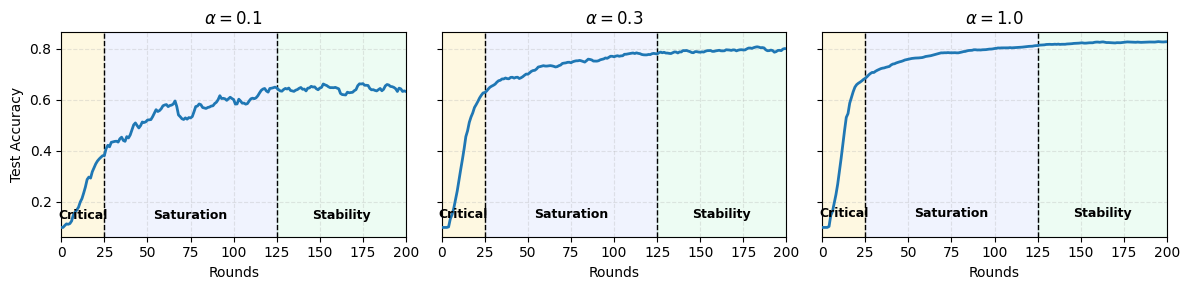

In [9]:
pdf_path = plot_criticalfl_accuracy_grid_labeled(
    df_crit,
    outdir=OUTPUT,
    save_pdf_name="criticalfl_accuracy_grid_smoothed.pdf",
    smooth=True,       # habilita suavização
    method="rolling",  # "rolling" ou "savgol"
    window=10,          # janela da média móvel (ou Savitzky–Golay)
    polyorder=2,       # usado apenas se method="savgol"
    show=True
)